In [1]:
import pandas as pd
df=pd.read_csv('PLED.csv')

#df.dropna(axis='columns',how='all'),remove the columns from 21 to 25 with no values at all 
df.drop(df.columns[21:26],axis=1,inplace=True)

# remove rows without any values or with all NaN, 1,048,575 entries turns into 584,513
df.dropna(axis='index',how='any',subset=['Customer ID'],inplace=True)

# remove rows with sku NaN, Price 0, and grand_total 0 or negative;  
bl_sku=df['sku'].isna()
df1=df.loc[(~bl_sku)&(df.price>0)&(df.grand_total>0)]

# drop sales_commission_code column 
df2=df1.drop(columns=['sales_commission_code'])

# change a few column names, increment_id to order_id, BI Status to BI_Status, 
      # create_at to order_date, category_name_1 to category, grand_total to subtotal, 
    # Customer Since to account_since, Customer ID to customer_id

df3=df2.rename(columns={"created_at":"order_date","grand_total":"total",
                        "increment_id":"order_id","category_name_1":"category",
                        "BI Status":"BI_Status","Customer Since":"account_since",
                       "Customer ID":"customer_id","Working Date":"working_date",
                       "FY":"fiscal_year"," MV ":"subtotal"})

# check if two columns of date working_date and order_date, mv and price are the same
import numpy as np
comparison_column = np.where(df3['order_date']==df3['working_date'],True, False)
comparision_mv=np.where(df3['price']==df3['subtotal'],True,False)

# remove "working_date","Year","Month","M-Y" columns 
df3=df3.drop(columns=["working_date","Year","Month","M-Y"])

# set item_id,customer_id,qty_ordered,order_id to int

df3['item_id']=df3['item_id'].astype(int)
df3['customer_id']=df3['customer_id'].astype(int)
df3['qty_ordered']=df3['qty_ordered'].astype(int)

# drop the subtotal column with many strings 
df3=df3.drop(columns=['subtotal'])

# convert order_date, account_since to datetime
df3['order_date']=pd.to_datetime(df3.order_date)
df3['account_since']=pd.to_datetime(df3.account_since)

# remove invalid data: 1. remove sku with "test" or "Test" & category with "\\N" or "Others"
f1=(df3['sku'].str.contains('test',na=False))
f2=(df3['sku'].str.contains('Test',na=False))
f3=(df3['category']!="\\N")
f4=(df3['category']!="Others")

df4=df3.loc[((~f1) & f3) |(~f2 & f3) ]
df4=df4.loc[~f1 & f4]

# show unique values of a few categorical columns

print('status list:', df4.status.unique())
print('payment method list:', df4.payment_method.unique())
print('category list:', df4.category.unique())

# save the new clean dataframe as a csv file, code: df4.to_csv('df4.csv')
# count the N.O of NaN in each column 
print(df4[:].isna().sum())

# replace NaN values in status and category 
df4['status']=df4['status'].fillna('missing_status')
df4['category']=df4['category'].fillna('Others')

# remove column 'total'
df4.drop(columns=['total'],inplace=True)

# list out the NO of unique values in each column, code: n=df4.nunique(axis=0), print("N.O of unique values in each column:",n)
n=df4.nunique(axis=0)
print("N.O of unique values in each column:",n)

# detecting any missing values in the dataframe
print(df4.isna().any())

# add a column called subtotal, price x qty_ordered - discount_amount for each item_id and convert the Pakistani currency to USD
df4['subtotal']=round((df4.price * df4.qty_ordered -df4.discount_amount)/176.83,2)

# remove the row with subtotal negative or less (those transactions are not real or normal purchase)
df4=df4[df4.subtotal>0]

# convert price into USD currency and set up to two decimal points 
df4['price']=round(df4.price/176.83,2)

print("99.9% subtotal is ", df4['subtotal'].quantile(0.999))
print("99.9% price is ", df4['price'].quantile(0.999))
print("price range:", df4['price'].describe())
print("subtotal range:", df4['subtotal'].describe())


D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,2,3,7,8,9,11,12,13,14,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


status list: ['complete' 'canceled' 'order_refunded' 'received' 'refund' 'closed'
 'fraud' 'holded' 'exchange' 'pending_paypal' 'paid' 'cod' 'pending' nan
 'processing' 'payment_review']
payment method list: ['cod' 'ublcreditcard' 'mygateway' 'cashatdoorstep' 'mcblite'
 'internetbanking' 'financesettlement' 'Payaxis' 'marketingexpense'
 'jazzwallet' 'jazzvoucher' 'customercredit' 'Easypay' 'Easypay_MA'
 'easypay_voucher' 'bankalfalah' 'apg']
category list: ["Women's Fashion" 'Beauty & Grooming' 'Soghaat' 'Mobiles & Tablets'
 'Appliances' 'Home & Living' "Men's Fashion" 'Kids & Baby'
 'Entertainment' 'Computing' 'Superstore' 'Health & Sports' 'Books'
 'School & Education' nan]
item_id              0
status              10
order_date           0
sku                  0
price                0
qty_ordered          0
total                0
order_id             0
category           163
discount_amount      0
payment_method       0
BI_Status            0
account_since        0
fiscal_year     

In [2]:
# save the df4 dataframe into the a csv file 
df4.to_csv('df4.csv')

In [41]:
# calculate how frequent customer places orders and assign it to frequency 
series_fr=df4.groupby('customer_id')['order_id'].nunique()

# calculate the RFM the monetary column, the total purchase amount group by customers
series_mt=df4.groupby('customer_id')['subtotal'].sum()

# now cauclate the recency column for customers and assign a scale from 0 to 99 based on the last purchase date 
series_re=df4.groupby('customer_id')['order_date'].max()

# create a series for customer_id without any repetition 
series_id=df4.groupby('customer_id')['customer_id'].unique()

# create a dataframe called rfm with customer_id as index to implement RFM model analysis for customer demographics
rfm=pd.DataFrame(series_re)
rfm['frequency']=series_fr
rfm['monetary']=series_mt

# change the order_date column name to recency_date 
rfm=rfm.rename(columns={"order_date":"recency_date"})

# turn the RFM columns into RFM score (set RFM column with percentile rank ), rfm['recency_score']=pd.qcut(rfm['recency_date'],10,labels=False)
# set the recency score based on 0-10 scale
rfm['recency_score']=round(rfm.recency_date.rank(pct=True) * 10,0)

# set the frequency score based on 0-10 scale; rfm['frequency_score']=pd.qcut(rfm['frequency'],10,labels=False) 
rfm['frequency_score']=round(rfm.frequency.rank(pct=True) * 10,0)
    
# set the monetary score based on 0-10 scale; rfm['monetary_score']=pd.qcut(rfm['monetary'],10,labels=False)
rfm['monetary_score']=round(rfm.monetary.rank(pct=True) * 10,0)

# reset index for dataframe rfm 
rfm=rfm.reset_index()

# change the score columns into int type from float
rfm['recency_score']=rfm['recency_score'].astype(int)
rfm['frequency_score']=rfm['frequency_score'].astype(int)
rfm['monetary_score']=rfm['monetary_score'].astype(int)

# get the top 20 customers in frequency and then by monetary 
rfm.nlargest(n=20,columns=['frequency','monetary'])

# check if every order has different status (now confirm the status is for order instead of item;)
st=df4.groupby('order_id')['status'].nunique()
st=st.sort_values(ascending=False)

# verify if every order can have different payment method and confirm there can be only one payment method for every order 
st=df4.groupby('order_id')['payment_method'].nunique()

# get the statistic description of the RFM dataframe  print(rfm.describe())


C:\Users\JINGRO~1\AppData\Local\Temp/ipykernel_40712/2132002699.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure,ax=plt.subplots()


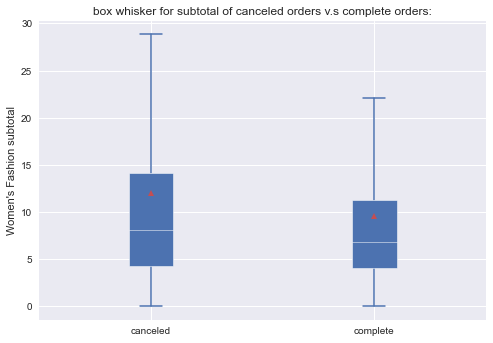

<Figure size 288x216 with 0 Axes>

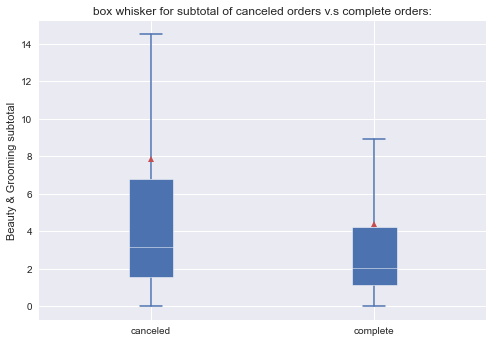

<Figure size 288x216 with 0 Axes>

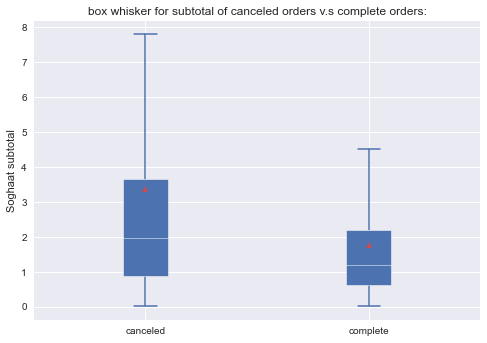

<Figure size 288x216 with 0 Axes>

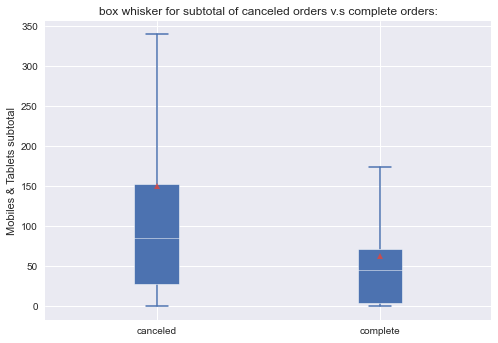

<Figure size 288x216 with 0 Axes>

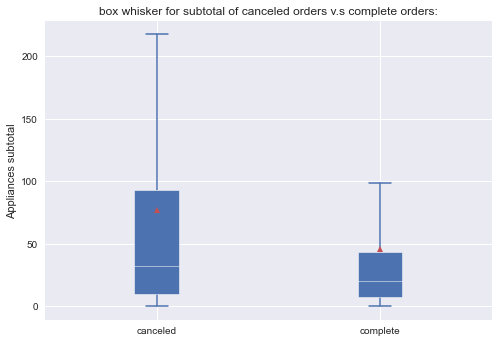

<Figure size 288x216 with 0 Axes>

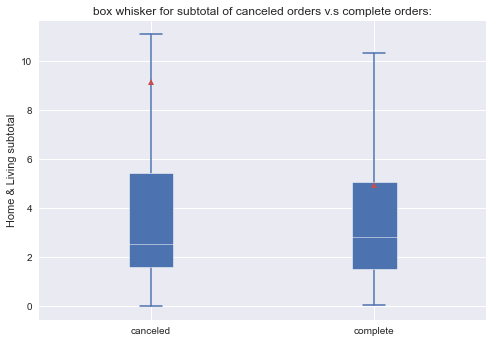

<Figure size 288x216 with 0 Axes>

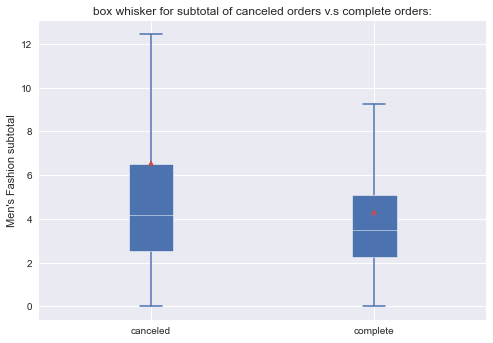

<Figure size 288x216 with 0 Axes>

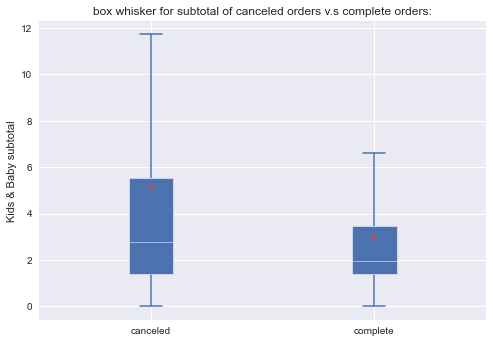

<Figure size 288x216 with 0 Axes>

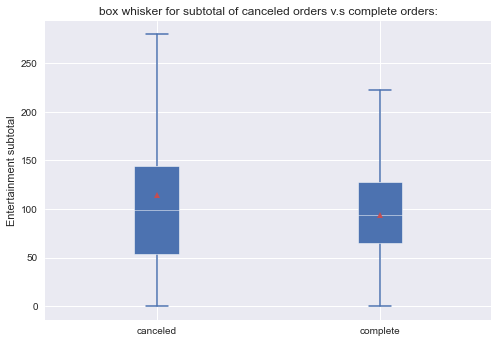

<Figure size 288x216 with 0 Axes>

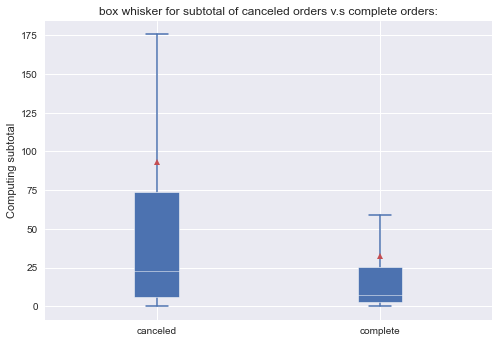

<Figure size 288x216 with 0 Axes>

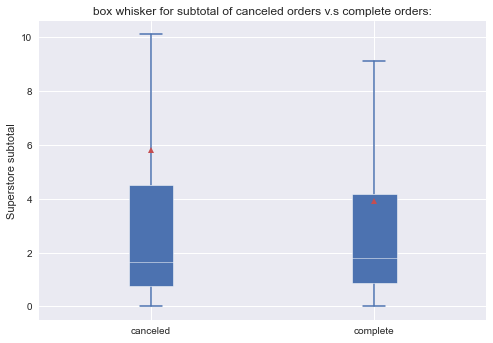

<Figure size 288x216 with 0 Axes>

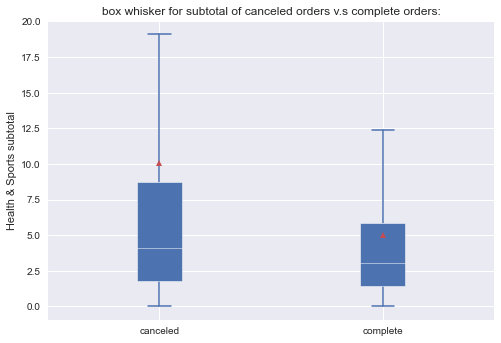

<Figure size 288x216 with 0 Axes>

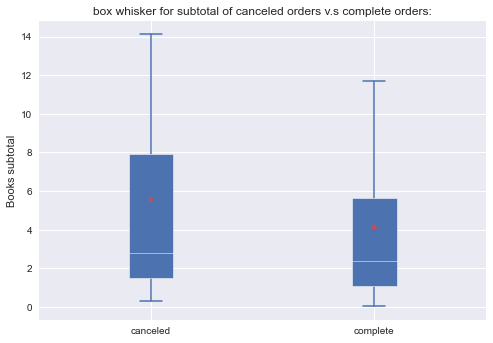

<Figure size 288x216 with 0 Axes>

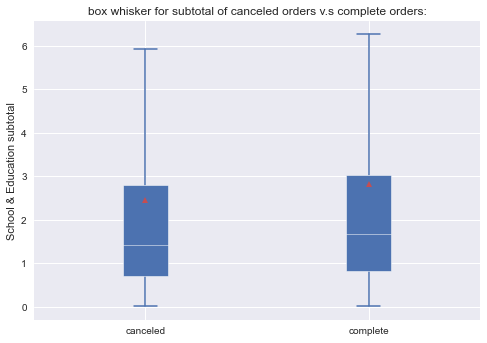

<Figure size 288x216 with 0 Axes>

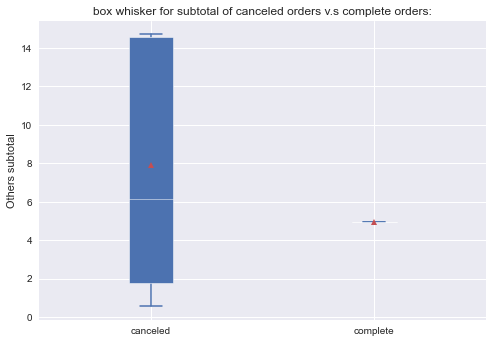

<Figure size 288x216 with 0 Axes>

In [2]:
# create box whisker for cancel orders and complete orders
import matplotlib.pyplot as plt
import numpy as np

# use for loop to create box whisker for every category in order to verify the pattern of canceled orders versus completed orders 

categories=df4['category'].unique()

for category in categories:
    d1=df4.loc[(df4.status=='canceled') & (df4.category==category)]
    d2=df4.loc[(df4.status=='complete') & (df4.category==category)]
    data=[d1['subtotal'],d2['subtotal']]
    plt.style.use('seaborn')
    figure,ax=plt.subplots()
    ax.boxplot(data,widths=0.2,patch_artist=True,
                showmeans=True, showfliers=False,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    ax.set_xticklabels(['canceled','complete'])
    ax.set_ylabel(category + " subtotal")
    ax.set_title('box whisker for subtotal of canceled orders v.s complete orders:')
    plt.figure(figsize=(4,3))
plt.show()


In [ ]:
# plot two line charts of the average price of different categories in complete and canceled transactions
import matplotlib.pyplot as plt
import numpy as np
df_com=df4.loc[df4['status']=='complete']
plt.style.use('seaborn-bright')
figure,ax=plt.subplots()
df_com=df_com.groupby('category')['price'].mean()
df_com=pd.DataFrame(df_com)
ax.plot(df_com.index,df_com['price'],marker=".",label='complete')

df_can=df4.loc[df4['status']=='canceled']  
df_can=df_can.groupby('category')['price'].mean()
df_can=pd.DataFrame(df_can)
ax.plot(df_can.index,df_can['price'],marker="v",linestyle="--",color="r",label='canceled')


ax.set_xticklabels(df_com.index,rotation=90)
ax.set_ylabel("avearge price of each category")
ax.set_title('average price of transactions by different categories')
plt.figure(figsize=(10,6))
ax.legend()
plt.show()




In [ ]:
# list of the unit price point for different categories 
for cat in categories:
    print(cat+' category unit price')
    cat=df4.loc[df4['category']==cat]
    print(cat['price'].describe())
    print(cat['price'].quantile(0.95))

C:\Users\JINGRO~1\AppData\Local\Temp/ipykernel_37532/3563830925.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure,ax=plt.subplots()


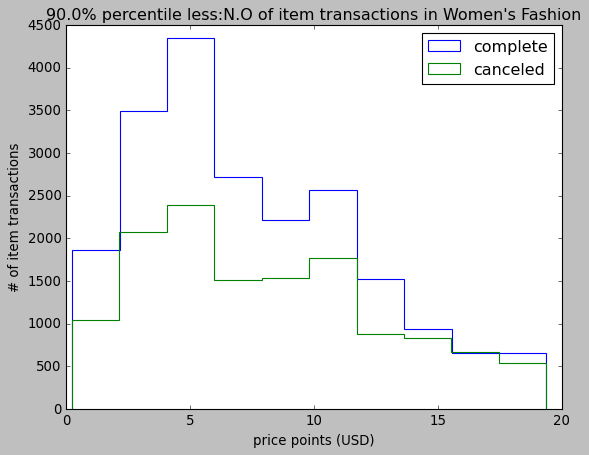

<Figure size 320x240 with 0 Axes>

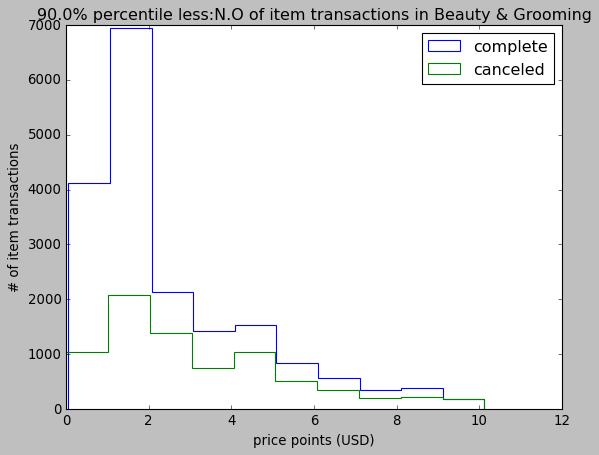

<Figure size 320x240 with 0 Axes>

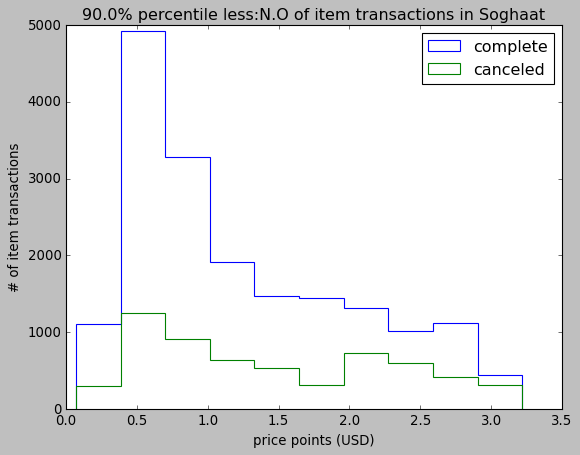

<Figure size 320x240 with 0 Axes>

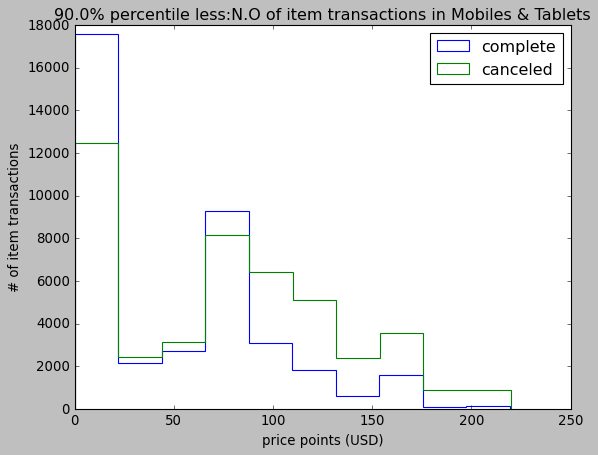

<Figure size 320x240 with 0 Axes>

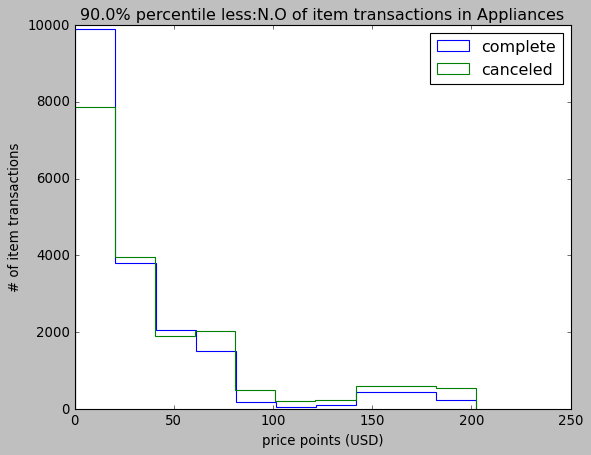

<Figure size 320x240 with 0 Axes>

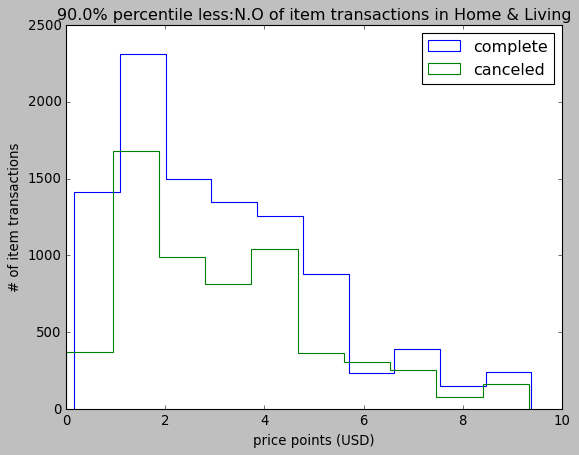

<Figure size 320x240 with 0 Axes>

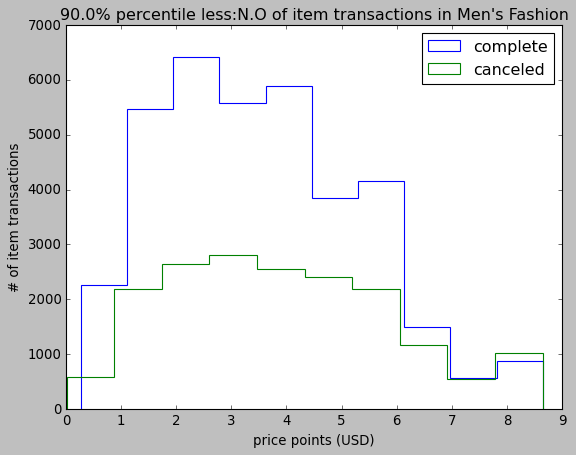

<Figure size 320x240 with 0 Axes>

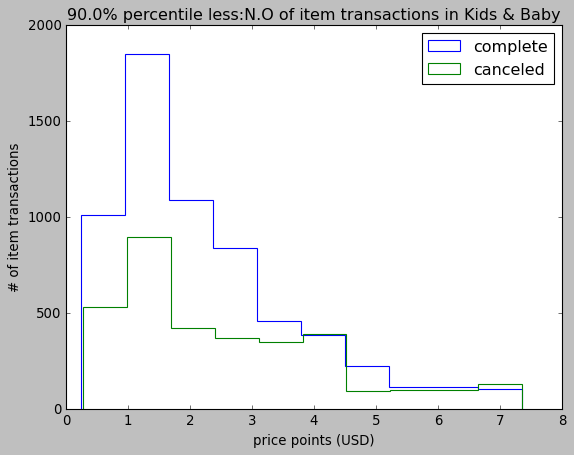

<Figure size 320x240 with 0 Axes>

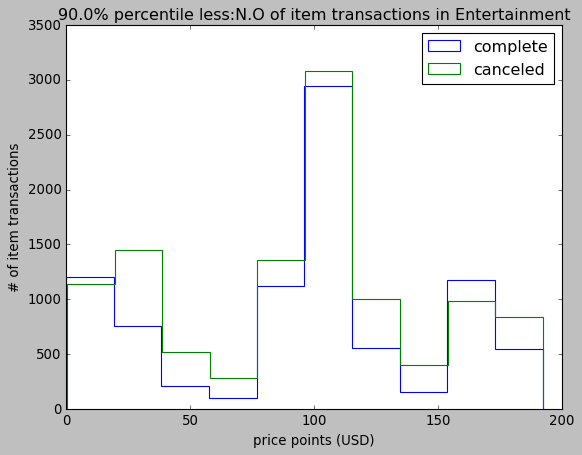

<Figure size 320x240 with 0 Axes>

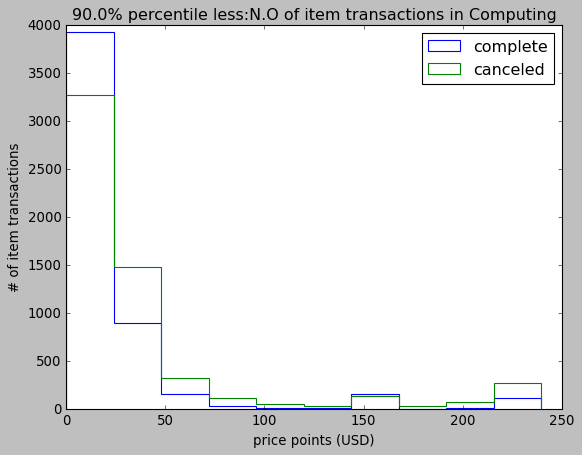

<Figure size 320x240 with 0 Axes>

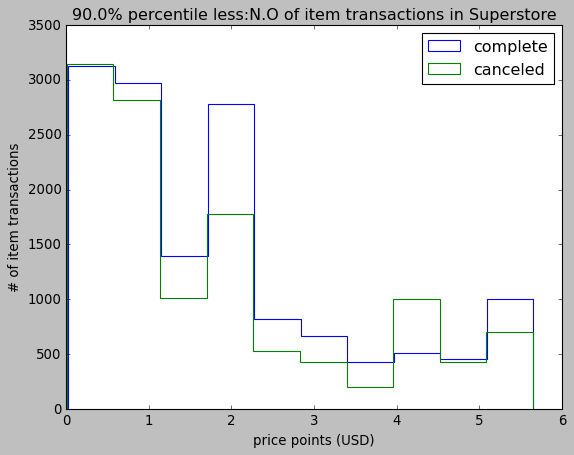

<Figure size 320x240 with 0 Axes>

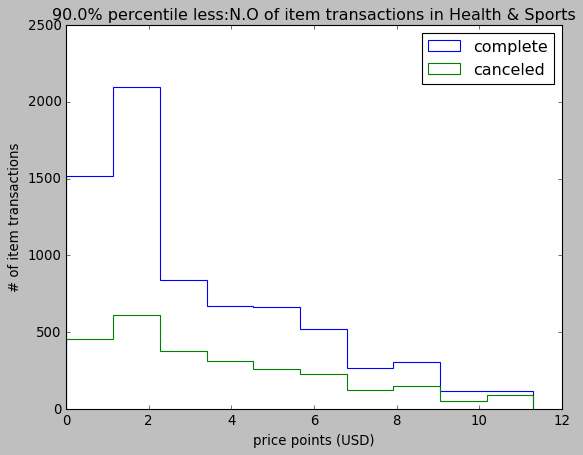

<Figure size 320x240 with 0 Axes>

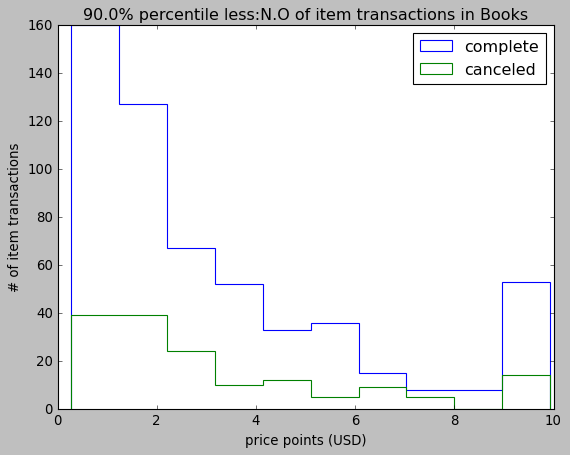

<Figure size 320x240 with 0 Axes>

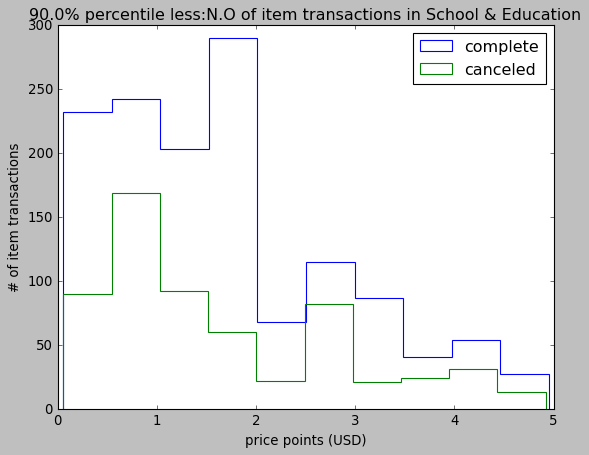

<Figure size 320x240 with 0 Axes>

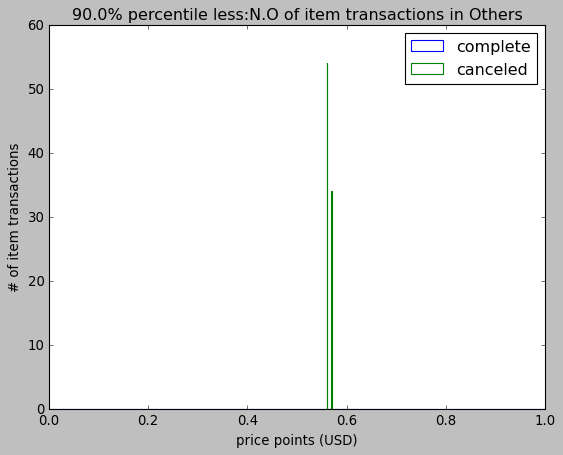

<Figure size 320x240 with 0 Axes>

In [31]:
# plot histograms for different categories by price bins and two main status (complete v.s canceled) 
# for x% percentile of price

categories=df4['category'].unique()
def plot_x(per,bin):
    for category in categories:
        plt.style.use('classic')
        figure,ax=plt.subplots()
        df_com=df4.loc[df4['category']==category]
        df_com=df_com.loc[df_com['price'] <= df_com['price'].quantile(per)]
        df_can=df_com
        df_can=df_can.loc[df_can['status']=='canceled']
        df_com=df_com.loc[df_com['status']=='complete']
        ax.hist(df_com['price'],bins=bin,histtype='step',label='complete')
        ax.hist(df_can['price'],bins=bin,histtype='step',label='canceled')
        ax.set_xlabel('price points (USD)')
        ax.set_ylabel('# of item transactions')
        ax.set_title(str(100*per)+"% percentile less:N.O of item transactions in " + category)
        ax.legend()
        plt.figure(figsize=(4,3))
    plt.show()

plot_x(0.9,10)

C:\Users\JINGRO~1\AppData\Local\Temp/ipykernel_40712/2536478932.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure,ax=plt.subplots()


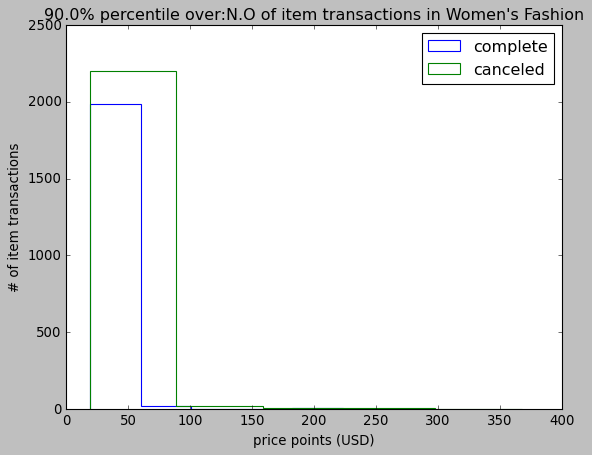

<Figure size 320x240 with 0 Axes>

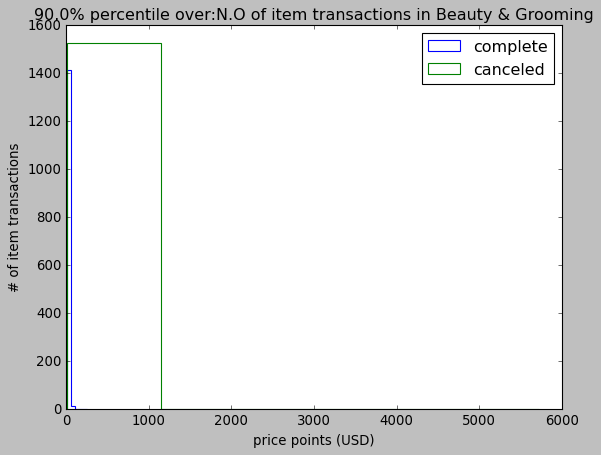

<Figure size 320x240 with 0 Axes>

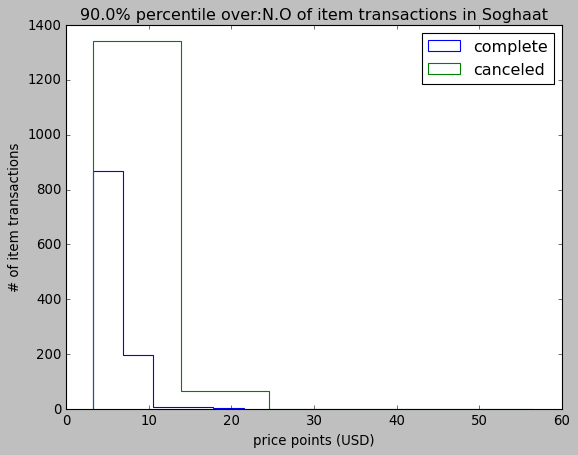

<Figure size 320x240 with 0 Axes>

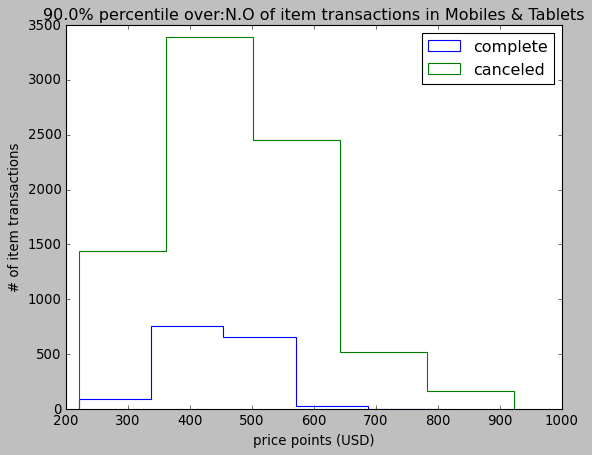

<Figure size 320x240 with 0 Axes>

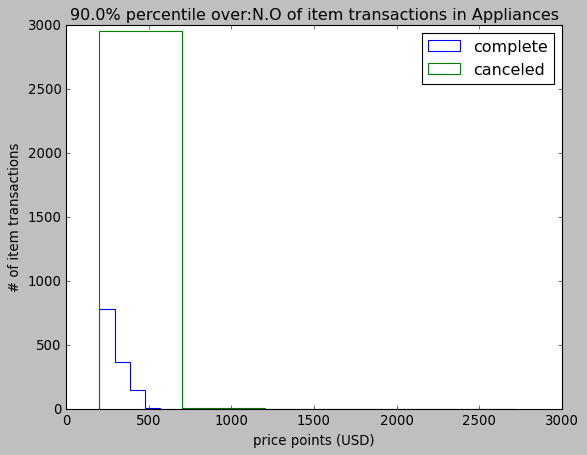

<Figure size 320x240 with 0 Axes>

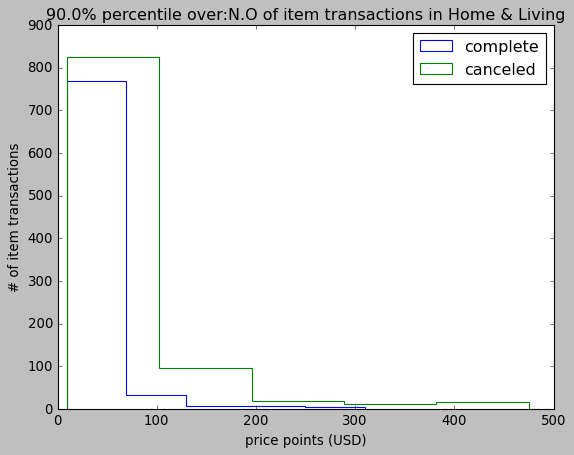

<Figure size 320x240 with 0 Axes>

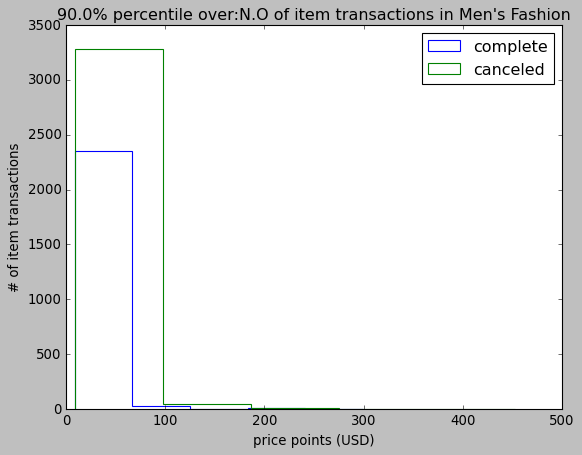

<Figure size 320x240 with 0 Axes>

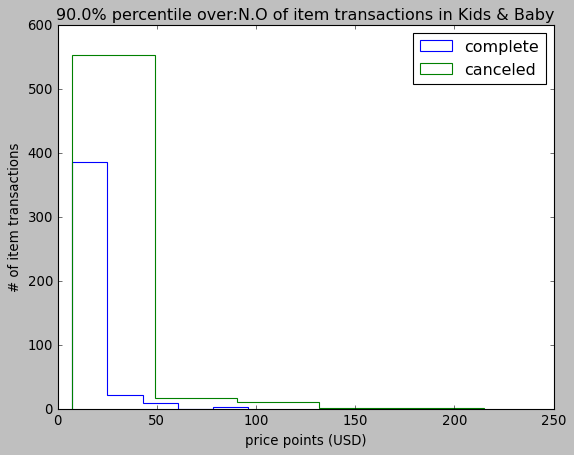

<Figure size 320x240 with 0 Axes>

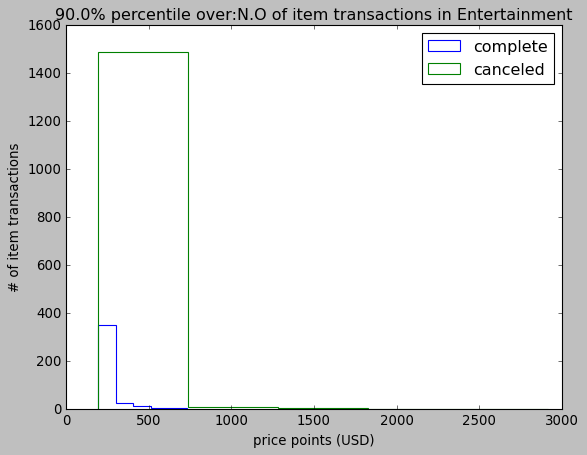

<Figure size 320x240 with 0 Axes>

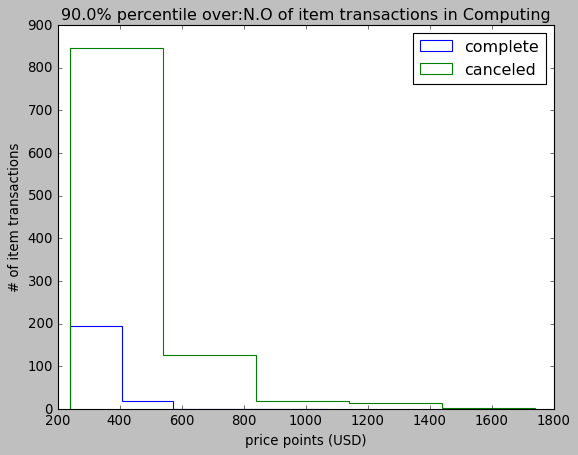

<Figure size 320x240 with 0 Axes>

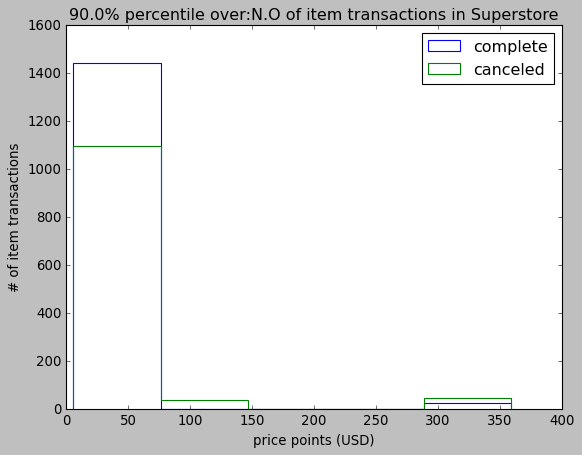

<Figure size 320x240 with 0 Axes>

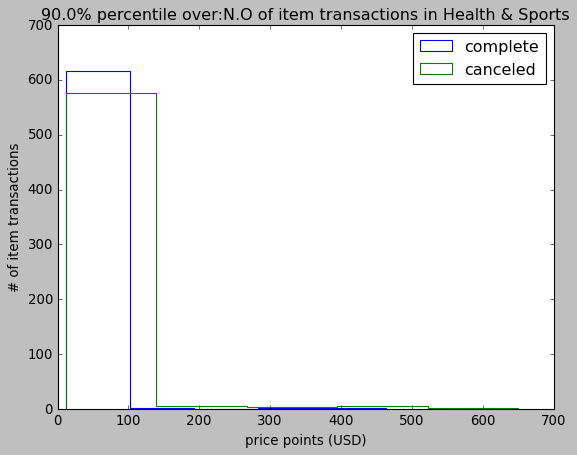

<Figure size 320x240 with 0 Axes>

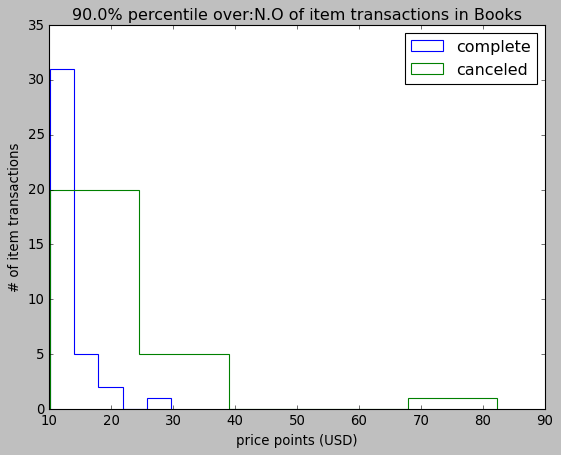

<Figure size 320x240 with 0 Axes>

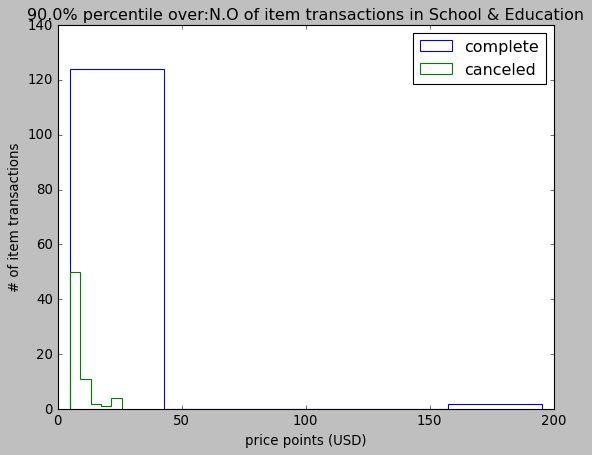

<Figure size 320x240 with 0 Axes>

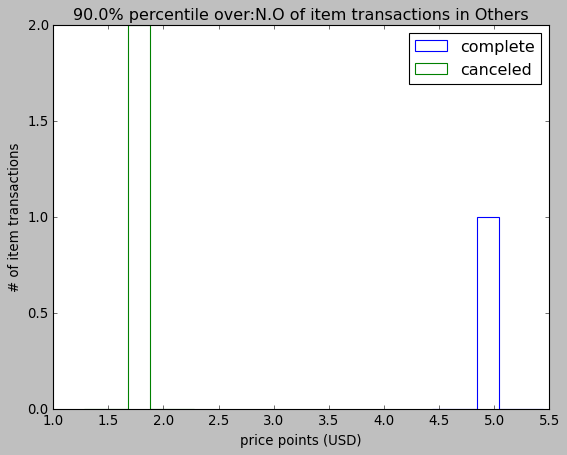

<Figure size 320x240 with 0 Axes>

In [3]:
# plot histograms for different categories by price bins and two main status (complete v.s canceled) 
# for price point higher than y% percentile

categories=df4['category'].unique()
def plot_y(per,bin):
    for category in categories:
        plt.style.use('classic')
        figure,ax=plt.subplots()
        df_com=df4.loc[df4['category']==category]
        df_com=df_com.loc[df_com['price'] > df_com['price'].quantile(per)]
        df_can=df_com
        df_can=df_can.loc[df_can['status']=='canceled']
        df_com=df_com.loc[df_com['status']=='complete']
        ax.hist(df_com['price'],bins=bin,histtype='step',label='complete')
        ax.hist(df_can['price'],bins=bin,histtype='step',label='canceled')
        ax.set_xlabel('price points (USD)')
        ax.set_ylabel('# of item transactions')
        ax.set_title(str(100*per)+"% percentile over:N.O of item transactions in " + category)
        ax.legend()
        plt.figure(figsize=(4,3))
    plt.show()

plot_y(0.9,5)

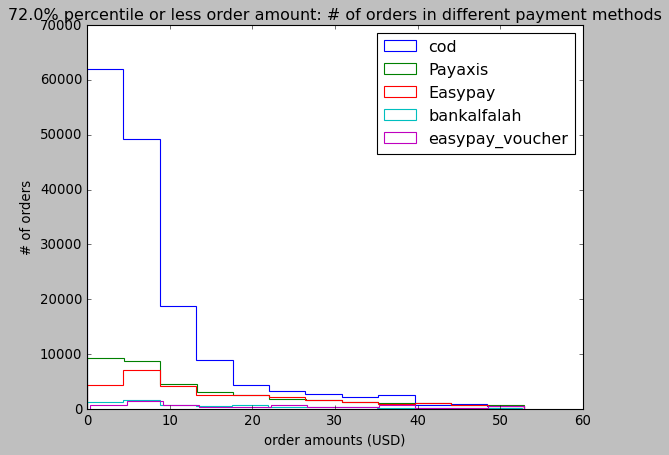

<Figure size 640x480 with 0 Axes>

In [73]:
# create a new dataframe df_om with just order, order amount and payment methods 
df4['payment_method'].unique()
df_om=df4.groupby('order_id')['subtotal'].sum()
df_om=pd.DataFrame(df_om)
df_om['payment_method']=df4.groupby('order_id')['payment_method'].unique()
df_om.reset_index(inplace=True)

# plot histograms for all orders by its subtotal bins less than its per percentile by five main payment terms
def plot_pc(per,bin):
    payments=['cod','Payaxis','Easypay','bankalfalah','easypay_voucher']
    plt.style.use('classic')
    figure,ax=plt.subplots()
    df4_per=df_om.loc[df_om['subtotal']<=df_om['subtotal'].quantile(per)]
    for payment in payments:    
        df_pay=df4_per.loc[df4_per.payment_method==payment]
        ax.hist(df_pay['subtotal'],bins=bin,histtype='step',label=payment)
    ax.set_xlabel('order amounts (USD)')
    ax.set_ylabel('# of orders')
    ax.set_title(str(100*per)+"% percentile or less order amount: # of orders in different payment methods")
    plt.figure()
    ax.legend()
    plt.show()
plot_pc(0.72,12)

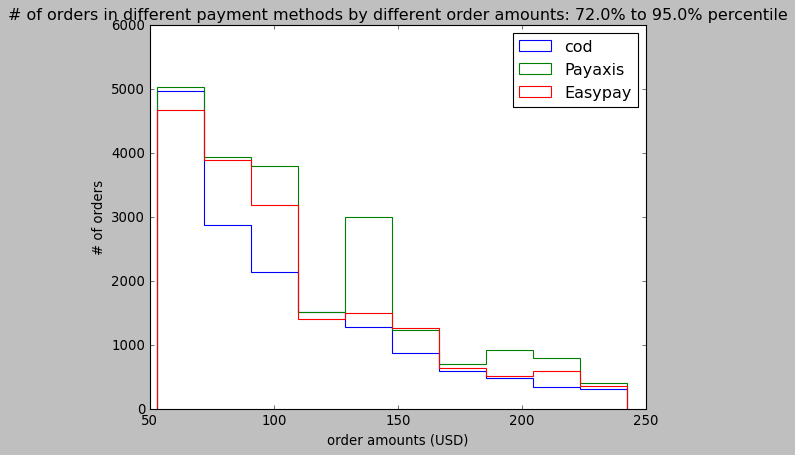

<Figure size 640x480 with 0 Axes>

In [72]:
# plot histograms for all categories by price bins more than per percentile of price by five main payment terms
def plot_pc(p1,p2,bin):
    payments=['cod','Payaxis','Easypay']
    plt.style.use('classic')
    figure,ax=plt.subplots()
    df4_per=df_om.loc[(df_om['subtotal']>=df_om['subtotal'].quantile(p1)) & (df_om['subtotal']<=df_om['subtotal'].quantile(p2))]
    for payment in payments:    
        df_pay=df4_per.loc[df4_per.payment_method==payment]
        ax.hist(df_pay['subtotal'],bins=bin,histtype='step',label=payment)
    ax.set_xlabel('order amounts (USD)')
    ax.set_ylabel('# of orders')
    ax.set_title("# of orders in different payment methods by different order amounts: "+str(p1*100)+"% to "+str(p2*100)+"% percentile")
    plt.figure()
    ax.legend()
    plt.show()
plot_pc(0.72,0.95,10)

,order_id,subtotal,payment_method
0,100001290,1.88,[cod]
1,100147443,11.03,[cod]
2,100147444,1.36,[cod]
3,100147445,13.86,[cod]
4,100147446,0.34,[cod]
...,...,...,...
367462,100562383,2.26,[cod]
367463,100562384,2.82,[cod]
367464,100562385,3.95,[cod]
367465,100562386,201.32,[bankalfalah]


In [ ]:
# create visualizations with Matplotlib and Seaborn 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
df6=df5[df5.frequency<=24]
_=plt.xlabel('how frequenct customers buy from us in two years')
_=plt.ylabel('number of customers in the frequency bins')
_=plt.hist(df6['frequency'],bins=12)
plt.show()

In [ ]:
# create visualizations with Matplotlib and Seaborn 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(8.27,11.27)})
_=sns.catplot(x="status",y="subtotal",data=df4,kind="box")
plt.xticks(rotation=90)
plt.show()

# create visualizations with Matplotlib and Seaborn 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
df6=df5[df5.frequency<=24]
_=plt.xlabel('how frequenct customers buy from us in two years')
_=plt.ylabel('number of customers in the frequency bins')
_=plt.hist(df6['frequency'],bins=12)
plt.show()

df6=df5.loc[(df5.frequency>24) & (df5.frequency<=168)]
sns.set()
_=plt.xlabel('how frequenct customers buy from us in two years')
_=plt.ylabel('number of customers in the frequency bins')
_=plt.hist(df6['frequency'],bins=12)
plt.show()

df6=df5.loc[(df5.frequency>168) & (df5.frequency<=504)]
sns.set()
_=plt.xlabel('how frequenct customers buy from us in two years')
_=plt.ylabel('number of customers in the frequency bins')
_=plt.hist(df6['frequency'],bins=12)
plt.show()